# Аналитика для крупного интернет-магазина

Вместе с отделом маркетинга мы подготовили список гипотез для увеличения выручки.  
В данном исследовании необходимо провести приоритезацию гипотез, запустить A/B-тест и проанализировать результаты.

**Данные хранятся в следующих файлах:**  
- `hypothesis.csv`
- `orders.csv`
- `visitors.csv`

**Описание данных**

Файл `hypothesis.csv` Хранит 9 гипотез по увеличению выручки интернет-магазина:  

    Hypothesis — краткое описание гипотезы;  
    Reach — охват пользователей по 10-балльной шкале;
    Impact — влияние на пользователей по 10-балльной шкале;
    Confidence — уверенность в гипотезе по 10-балльной шкале;
    Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.  
    
Файл `orders.csv` с результатами А/В-теста:  

    transactionId — идентификатор заказа;
    visitorId — идентификатор пользователя, совершившего заказ;
    date — дата, когда был совершён заказ;
    revenue — выручка заказа;
    group — группа A/B-теста, в которую попал заказ.
Файл `visitors.csv` с результатами А/В-теста:  

    date — дата;
    group — группа A/B-теста;
    visitors — количество пользователей в указанную дату в указанной группе A/B-теста



## Исследование данных и их предобработка

Начнем с импорта необходимых для работы библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import datetime as dt
import numpy as np
from pandas.plotting import register_matplotlib_converters
import warnings

Испортируем предоставленные файлы и сохраним в переменных с такими же названиями:

In [2]:
try:
    hypothesis, orders, visitors = (pd.read_csv('/datasets/hypothesis.csv'),
                       pd.read_csv('/datasets/orders.csv'),
                       pd.read_csv('/datasets/visitors.csv'))
except:
    hypothesis, orders, visitors = (pd.read_csv('hypothesis.csv'),
                       pd.read_csv('orders.csv'),
                       pd.read_csv('visitors.csv'))

Поскольку у нас 3 датафрейма, напишем небольшую обзорную функцию, которая даст нам все первичные сведения о датафрейме:

In [3]:
def view_func(data):
    '''
    Обзорная функция для получения первичной информации о датафрейме
    -Вывод первых пяти строк
    -Применение функции info()
    -Доля пропущенных значений по столбцам
    -Сумма явных дубликатов
    '''
    print('Внешний вид датафрейма:')
    display(data.head(5))
    print('``````````````````````````````````````````````````')
    print('Типы данных, кол-во строк и столбцов:')
    print(data.info())
    print('``````````````````````````````````````````````````')
    print('Доля пропущенных значений:')    
    print(data.isnull().mean())
    print('``````````````````````````````````````````````````')
    print('Количество явных дубликатов:')
    print(data.duplicated().sum())
    print('``````````````````````````````````````````````````')

### Предобработка данных таблицы hypothesis

Изучим данные файла `hypothesis`

In [4]:
view_func(hypothesis)

Внешний вид датафрейма:


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


``````````````````````````````````````````````````
Типы данных, кол-во строк и столбцов:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
None
``````````````````````````````````````````````````
Доля пропущенных значений:
Hypothesis    0.0
Reach         0.0
Impact        0.0
Confidence    0.0
Efforts       0.0
dtype: float64
``````````````````````````````````````````````````
Количество явных дубликатов:
0
``````````````````````````````````````````````````


Данные без пропусков и дубликатов, однако приведем названия колонок к нижнему регистру:

In [5]:
hypothesis = hypothesis.rename(columns=str.lower)
hypothesis.head(5)

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


### Предобработка данных таблицы orders

Изучим данные файла `orders`

In [6]:
view_func(orders)

Внешний вид датафрейма:


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


``````````````````````````````````````````````````
Типы данных, кол-во строк и столбцов:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
None
``````````````````````````````````````````````````
Доля пропущенных значений:
transactionId    0.0
visitorId        0.0
date             0.0
revenue          0.0
group            0.0
dtype: float64
``````````````````````````````````````````````````
Количество явных дубликатов:
0
``````````````````````````````````````````````````


Данные без пропусков и дубликатов, однако приведем названия колонок к нормальному виду, и поменяем тип данных в колонке date:

In [7]:
orders = orders.rename(columns={'transactionId' : 'transaction_id',
                                'visitorId' : 'visitor_id'})
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [8]:
display(orders.head(5))
orders.info()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


### Предобработка данных таблицы visitors

In [9]:
view_func(visitors)

Внешний вид датафрейма:


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


``````````````````````````````````````````````````
Типы данных, кол-во строк и столбцов:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None
``````````````````````````````````````````````````
Доля пропущенных значений:
date        0.0
group       0.0
visitors    0.0
dtype: float64
``````````````````````````````````````````````````
Количество явных дубликатов:
0
``````````````````````````````````````````````````


Данные без пропусков и дубликатов, как и в таблице orders, поменяем тип данных в колонке date:

In [10]:
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [11]:
display(visitors.head(5))
visitors.info()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


### Промежуточный вывод

В предоставленных таблицах мы исправили типы данных в колонках с датами для удобства будущих вычислений, а также привели все названия столбцов в однообразному виду.
Явных дубликатов не обнаружено.

##  Приоритизация гипотез

### Расчеты

Применим фреймворк ICE для приоритизации гипотез и отсортируем их по убыванию приоритета

In [12]:
pd.set_option("display.max_colwidth", 1000)
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [13]:
hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
hypothesis['ICE'] = round(hypothesis['ICE'],2)
display(hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False))

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Применим фреймворк RICE для приоритизации гипотез и отсортируйте их по убыванию приоритета

In [14]:
hypothesis['RICE'] = (hypothesis['reach'] * 
                      hypothesis['impact'] *
                      hypothesis['confidence']) / hypothesis['efforts']
display(hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False))

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


### Промежуточный вывод

Наиболее перспективные гипотезы по ICE - 8,0,7,6  
Однако по RICE наиболее перспективными стали гипотезы - 7,2,0,6.  
Это связано с тем, что в фреймворке RICE появляется аргумент reach, который учитывает количество пользователей, которая она затронет, а у гипотезы №7, которая стала самой популярной reach равен 10.

## Анализ A/B-теста

### Подготовка данных

#### Изучение получившихся данных

Изучим данные, которые получились в результате проведения А/В-тестов.

In [15]:
display(orders['group'].unique())
display(visitors['group'].unique())

array(['B', 'A'], dtype=object)

array(['A', 'B'], dtype=object)

В тесте 2 группы - А и В

Изучим период проведения теста:

In [16]:
print(orders['date'].min())
print(orders['date'].max())

2019-08-01 00:00:00
2019-08-31 00:00:00


Период проведения теста - 1 месяц с 1 августа по 31 августа 2019 года.

Проверим количество пользователей в каждой группе, а также есть ли у нас пользователи, которые попали в обе группы:

In [17]:
orders.head(5)

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [18]:
orders.pivot_table(index='group',
                  values='visitor_id',
                  aggfunc='count')

,visitor_id
group,
A,557
B,640


In [19]:
orders_a = orders.query('group == "A"')
orders_b = orders.query('group == "B"')
c = []
for i in orders_a['visitor_id']:
    for j in orders_b['visitor_id']:
        if i == j:
            c.append(i)
            break
 
print(len(c))

89


Мы обнаружили, что у нас две группы А и В по 557 и 640 пользователей соответственно, а также 89 пользователей, которые встречаются в обеих группах.

#### Обработка данных

Обработаем результаты orders и visits и сделаем выводы на основании полученных данных.

- Создадим датафрейм datesGroups с уникальными парами значений 'date' и 'group', таблицы orders. Избавьтесь от дубликатов методом drop_duplicates()  

- Объявим переменную ordersAggregated, содержащую:

    дату;  
    группу A/B-теста;  
    число уникальных заказов в группе теста по указанную дату включительно;  
    число уникальных пользователей, совершивших хотя бы 1 заказ в группе теста по указанную дату включительно;  
    суммарную выручку заказов в группе теста по указанную дату включительно
    
- Объявим переменную visitorsAggregated, содержащую:

    дату;  
    группу A/B-теста;  
    количество уникальных посетителей в группе теста по указанную дату включительно  

- Определим переменную cumulativeData, объединив ordersAggregated и visitorsAggregated по колонкам 'date', 'group' методом merge()


In [20]:
display(orders.head(5))
display(visitors.head(5))

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [21]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])


# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)

cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]
print(cumulativeData.head(5)) 


        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      24      20   148579       719
1 2019-08-01     B      21      20   101217       713
2 2019-08-02     A      44      38   242401      1338
3 2019-08-02     B      45      43   266748      1294
4 2019-08-03     A      68      62   354874      1845


Объявим переменные cumulativeRevenueA и cumulativeRevenueB, в которых сохраним данные о датах, выручке и числе заказов в группах A и B.
Построим графики кумулятивной выручки по дням по группам.

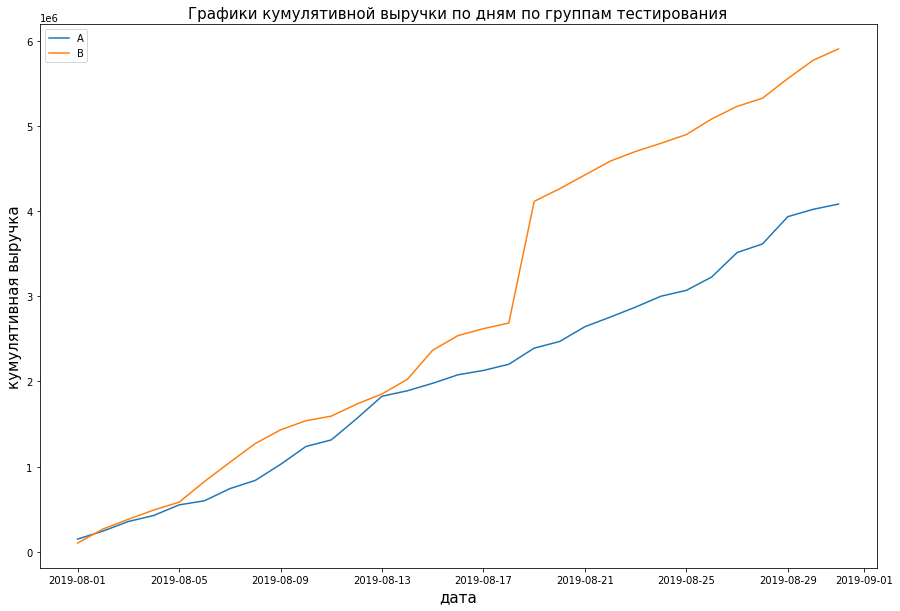

In [22]:
# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters()

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.figure(figsize=(15,10))
plt.title('Графики кумулятивной выручки по дням по группам тестирования',fontsize = 15)
plt.xlabel('дата',fontsize = 15)
plt.ylabel('кумулятивная выручка', fontsize = 15)
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.legend();

В середине теста сегмент В вырвался вперед и продолжал лидировать в течении всего теста. Похоже, что аномально большие заказы влияют на результаты тестирования, и в будущем анализе от них нужно будет избавиться.

Для каждой группы построим графики кумулятивного среднего чека по дням

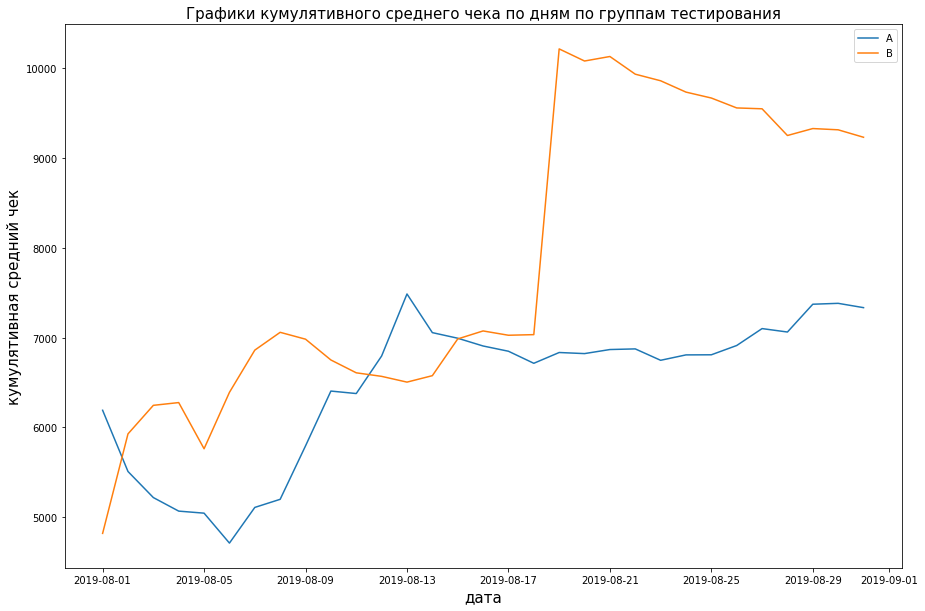

In [23]:
plt.figure(figsize=(15,10))
plt.title('Графики кумулятивного среднего чека по дням по группам тестирования',fontsize = 15)
plt.xlabel('дата',fontsize = 15)
plt.ylabel('кумулятивная средний чек', fontsize = 15)
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend();

Средние комулятивные значения очень колеблются, из-за присутствия выбросов и аномалий, делать какие-то выводы по этим показателям рано.  

Построим график относительно различия кумулятивного среднего чека группы B к группе A.

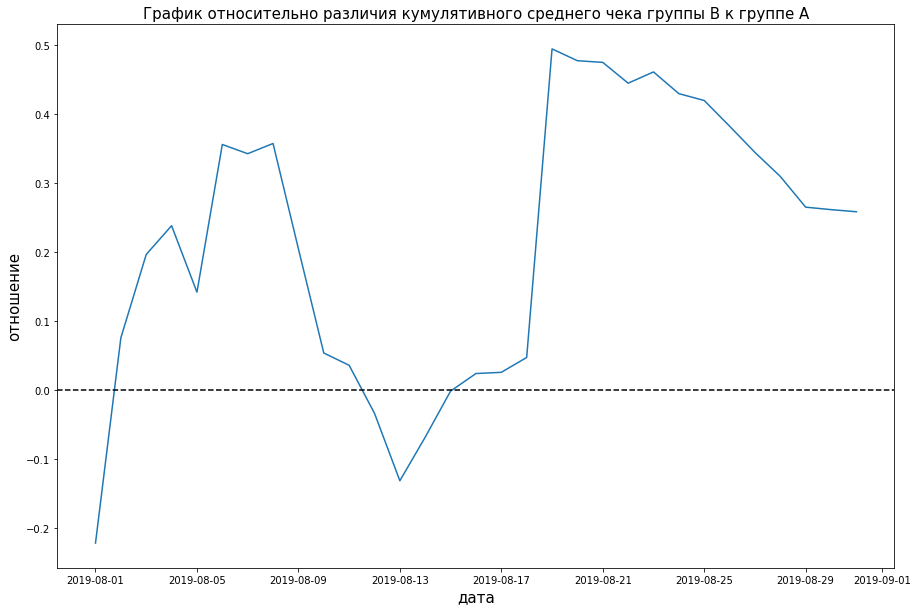

In [24]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.figure(figsize=(15,10))
plt.title('График относительно различия кумулятивного среднего чека группы B к группе A',fontsize = 15)
plt.xlabel('дата',fontsize = 15)
plt.ylabel('отношение', fontsize = 15)
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--');

График отражает зависимость размера среднего чека группы В к группе А. На графике есть несколько резких изменений, вероятно в эти дни как раз и происходили аномальные заказы.  

Построим графики кумулятивной конверсии по дням по группам.

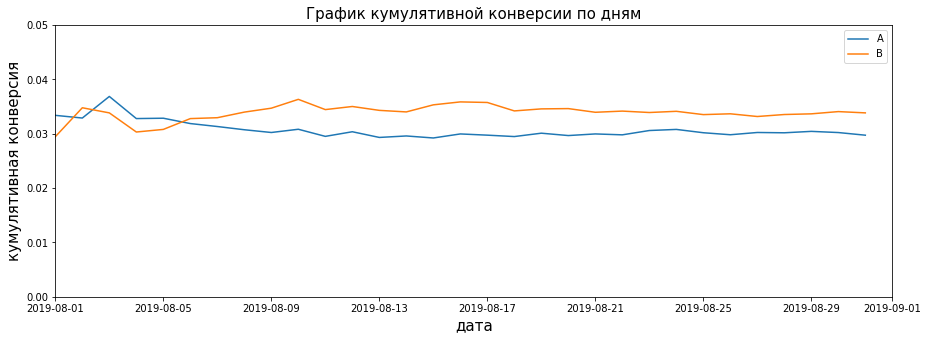

In [25]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(15,5))
plt.title('График кумулятивной конверсии по дням',fontsize = 15)
plt.xlabel('дата',fontsize = 15)
plt.ylabel('кумулятивная конверсия', fontsize = 15)
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
# задаем масштаб осей
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), 0, 0.05]);

В самом начале теста сегмент А имел большую конверисию, но постепенно сегемент В выравнялся у некого среднего значения, превышающего средню конверсию в сегменте А. 

Построим график относительного различия кумулятивной конверсии группы B к группе A

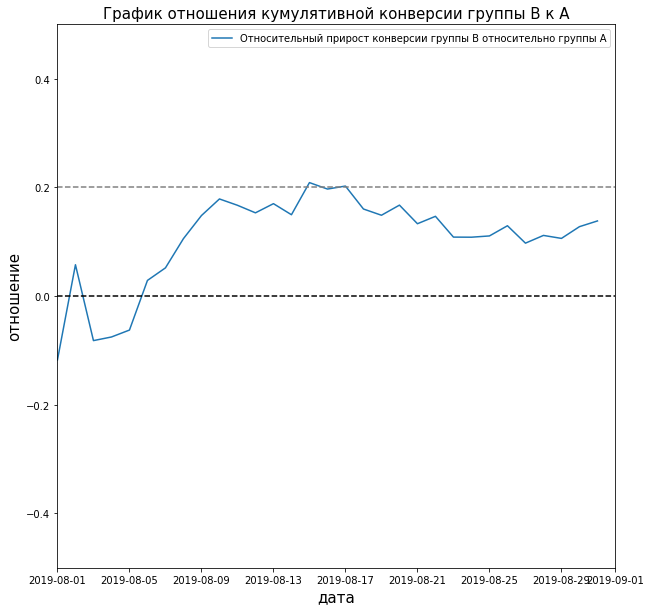

In [26]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(10,10))
plt.title('График отношения кумулятивной конверсии группы В к А',fontsize = 15)
plt.xlabel('дата',fontsize = 15)
plt.ylabel('отношение', fontsize = 15)
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.axis(["2019-08-01", '2019-09-01', -0.5, 0.5]);

Относительный прирост конверсии группы В к группе А сильно колеблется в самом начале теста, но на 12 день устанавливается в районе прироста в 20% и постепенно снижается к концу теста.

Построим точечный график количества заказов по пользователям. 

          userId  orders
1023  4256040402      11
591   2458001652      11
569   2378935119       9
487   2038680547       8
44     199603092       5
744   3062433592       5
55     237748145       5
917   3803269165       5
299   1230306981       5
897   3717692402       5


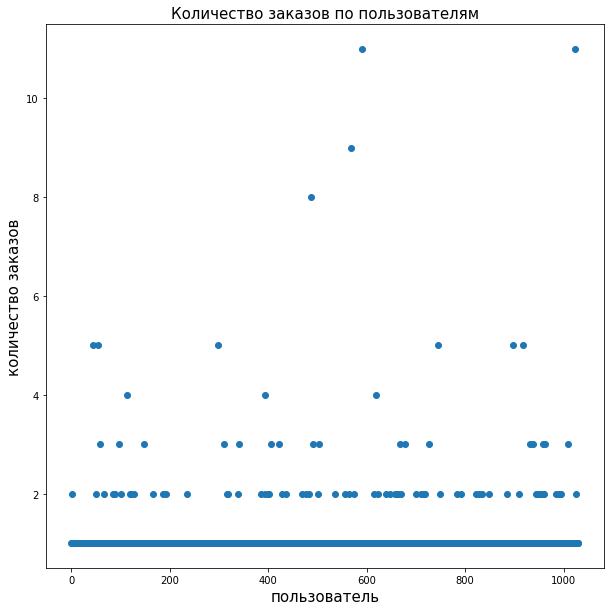

In [27]:
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
ordersByUsers.columns = ['userId', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10))


x_values = pd.Series(range(0,len(ordersByUsers)))
plt.figure(figsize=(10,10))
plt.title('Количество заказов по пользователям',fontsize = 15)
plt.xlabel('пользователь',fontsize = 15)
plt.ylabel('количество заказов', fontsize = 15)
plt.scatter(x_values, ordersByUsers['orders']) 
# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(ordersByUsers)))

По получившемуся графику можно сказать, что пользователей совершивших более 2-х заказов очень мало, посчитаем 95-й и 99-й перцентили количества заказов на пользователя для точного определения границы аномальных пользователей.

In [28]:
print(np.percentile(ordersByUsers['orders'], [90, 95, 99])) 

[1. 2. 4.]


Всего 5% пользователей, совершивших 2 и более заказов, и всего 1%, которые совершили больше 4.

Посмотрим на распределение данных по стоимости заказов на графике и посчитаем 95 и 99 перцентили для них:

      transaction_id  visitor_id       date  revenue group
425        590470918  1920142716 2019-08-19  1294500     B
1196      3936777065  2108080724 2019-08-15   202740     B
858        192721366  1316129916 2019-08-27    93940     A
1136       666610489  1307669133 2019-08-13    92550     A
744       3668308183   888512513 2019-08-27    86620     B
682       1216533772  4266935830 2019-08-29    78990     B
662       1811671147  4266935830 2019-08-29    78990     A
743       3603576309  4133034833 2019-08-09    67990     A
1103      1348774318  1164614297 2019-08-12    66350     A
1099       316924019   148427295 2019-08-12    65710     A


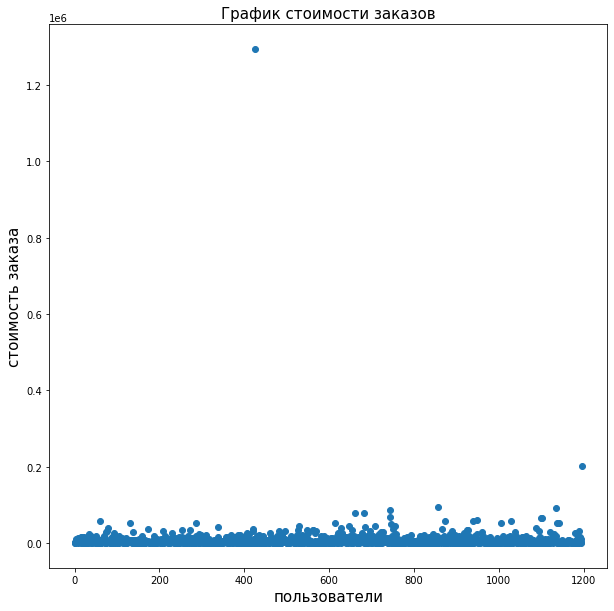

In [29]:
print(orders.sort_values(by='revenue', ascending=False).head(10))

x_values = pd.Series(range(0, len(orders['revenue'])))
plt.figure(figsize=(10,10))
plt.title('График стоимости заказов', fontsize = 15)
plt.xlabel('пользователи',fontsize = 15)
plt.ylabel('стоимость заказа', fontsize = 15)
plt.scatter(x_values, orders['revenue']);


Посмотрим на этот же график, немного смасштабировав его:

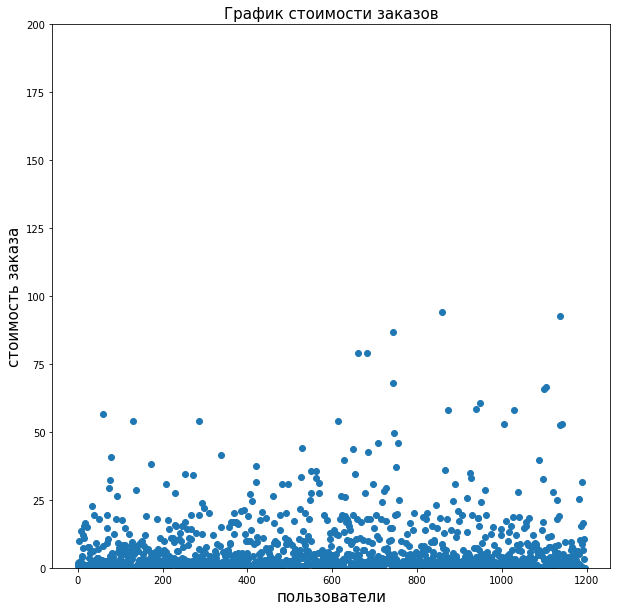

In [30]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.figure(figsize=(10,10))
plt.title('График стоимости заказов', fontsize = 15)
plt.xlabel('пользователи',fontsize = 15)
plt.ylabel('стоимость заказа', fontsize = 15)
plt.ylim(0, 200)
plt.scatter(x_values, orders['revenue']/1000);


In [31]:
print(np.percentile(orders['revenue'], [90,95,99]))

[18168.  28000.  58233.2]


Мы установили, что всего 5% заказов стоимостью более 28000 и 1%, которые дороже 58000. 

### Статистические тесты по "сырым" данным

Теперь посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным, без удаления аномалий. Для этого объявим переменные sampleA и sampleB, в которых пользователям с заказами будет соответствовать число заказов пользователя. А пользователям без заказов — нули.  

In [32]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

pd.Series(0, index=np.arange(visitors['visitors'].sum() - len(ordersByUsersA['orders'])), name='orders')

[ordersByUsersA['orders'],pd.Series(0, index=np.arange(visitors['visitors'].sum() - len(ordersByUsersA['orders'])), name='orders')] 

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange((visitors['visitors'][visitors['group']== 'A']).sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange((visitors['visitors'][visitors['group']== 'B']).sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)


sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                (visitors['visitors'][visitors['group']== 'A']).sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                (visitors['visitors'][visitors['group']== 'B']).sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Проведем проверки критерием Манна-Уитни, который применяется для оценки различий между двумя независимыми выборками по уровню какого-либо признака, измеренного количественно.  

`Сформулируем гипотезы.` 

**Нулевая**: различий в среднем количестве заказов между группами нет

**Альтернативная**: различия в среднем между группами есть

Уровень статистической значимости alpha зададим = 0.05. 


In [33]:
print("{0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

0.01679
0.138


p-value меньше чем 0.05, значит нулевую гипотезу можно отвергнуть и предположить, что есть статистически значимые различия в среднем количестве заказов между группами А и В.  
Относительный прирост среднего группы В к конверсии группы А равен 13,8%.  


Теперь сравним средние чеки по "сырым" данным.  

**Нулевая гипотеза**: различий в среднем чеке между группами нет.

**Альтернативная гипотеза**: различия в среднем чеке между группами есть.

Уровень статистической значимости alpha зададим = 0.05.

In [34]:
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

0.729
0.259


P-value больше 0.05 - значит статистически значимого различия между средними чеками в друх группах нет, нулевую гипотезу не отвергаем.  
А вот относительное среднее между двумя группами разнится почти на 26%. 

### Статистические тесты по "очищенным" данным

Приступим к подготовке очищенных от аномалий данных.
Как мы уже выяснили, 95-й и 99-й перцентили средних чеков равны 28000 и 58233 рублям. А 95-й и 99-й перцентили числа заказов на одного пользователя равны 2 и 4 заказам на пользователя.
Принимаем за аномальных пользователей тех, кто совершил более 2 заказов, или совершил заказ на сумму свыше 28000 рублей. Так мы уберём 5% пользователей с наибольшим числом заказов и 5% заказов с наибольшей стоимостью.

In [35]:
ab = np.percentile(ordersByUsers['orders'], 95)
ac = np.percentile(orders['revenue'], 95)

usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > ab]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > ab]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > ac]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
dtype: int64


Посчитаем статистическую значимость различия среднего количества заказов после удаления аномальных пользователей. Как и ранее, сформулируем гипотезы. 

**Нулевая гипотеза**: различий в среднем количестве заказов между группами нет.  

**Альтернативная гипотеза**: различия в среднем между группами есть.  

Уровень статистической значимости alpha, как и ранее = 0.05.

In [36]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                (visitors['visitors'][visitors['group']== 'A']).sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                (visitors['visitors'][visitors['group']== 'B']).sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 
print('{0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

0.01304
0.173


Как и в случае с "сырыми" данными, статистическая значимость достигнута,  нулевую гипотезу можно отвергнуть и предположить, что есть статистически значимые различия в среднем количестве заказов между группами А и В. А сегмент В значительно лучше сегмента А.

Посчитаем статистическую значимость различия средних чеков после удаления аномальных пользователей.  

**Нулевая гипотеза**: различий в среднем чеке между группами нет. 

**Альтернативная гипотеза**: различия в среднем чеке между группами есть.

Уровень статистической значимости alpha, как и ранее = 0.05.

In [37]:

print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

0.738
-0.020


P-value почти не изменился, но разница между сегментами сократилась с 25% до -2%.  
Общие выводы не изменились, результаты теста такие же, как и в "сырых" данных

## Вывод

По результатам проведенного А/В-теста можно сделать следующие выводы:  
- Есть статистически значимое различия по среднему количеству заказов как между группами по «сырым», так и по данным после фильтрации аномалий;
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;


Исходя из обнаруженных фактов, тест следует остановить и признать его успешным. 
Мы определили, что при статистически одинаковых стредних чеках в группах А и В, количество заказов в группе В больше, чем в группе А.   
Проведенные тесты так же подтверждают данные, которые мы получили по кумулятивной конверсии группы В к группе А.